# Code for generating Figure 5

##  "Error correction also improves more realistic Crick-like switches"

This Python notebook contains code for generating the fifth figure from the paper "Storing long-lived memories via molecular error correction: a minimal mathematical model of Crick's memory switch".

In [2232]:
%load_ext autoreload
%autoreload 2
    
# imports
import numpy as np
import matplotlib.pyplot as plt

import pickle


from functions.fsp import enumerate_states_box
from functions.fsp import build_generator_fsp, solve_cme_fsp
from functions.fsp import get_rxn_list_crick_binding, get_rxn_list_crick_full
from functions.fsp import prop_crick_full, stoich_crick_full
from functions.fsp import joint_marginal_over_vars


from functions.solutions import get_probs_crick, get_probs_ncrick
from functions.MI import get_MI

from functions.gillespie import simulate_ssa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2136]:
# aesthetics
lw = 4
c_red = (1,0,0)
c_green = np.array([57,181,74])/255

c_eps_low = 'palevioletred'
c_eps_med = 'hotpink'
c_eps_hi = 'pink'

c_k_low = 'saddlebrown'
c_k_med = 'darkorange'
c_k_hi = (255/255, 184/255, 74/255)

c_b_hi = 'tomato'
c_b_med = 'crimson'
c_b_low = 'maroon'

c_N_low = 'indigo'
c_N_med = 'darkviolet'
c_N_hi = 'mediumorchid'

sim_colors = ['chocolate', 'fuchsia', 'deepskyblue', 'gold'] 

In [2138]:
# saving-related utility function
results_folder = 'results/fig5/'
format_list = ['.png', '.svg', '.pdf']

def save_file(name):
    for end in format_list:
        plt.savefig(results_folder+name+end, bbox_inches='tight', transparent=True)
    return

<center>
<img src="fig_images/fig5-realistic.png" width="600"/></center>

(a) Schematic of more realistic model's reaction list. Left: monomer dynamics, which includes conversion between `active' and `reservoir' molecules. Right: dimer dynamics, which includes binding and unbinding. (b) Example stochastic simulation ($\gamma = 1, \epsilon = 0.01, k = 10, b_f = 1, b_r = 0.1, \alpha = 0.7, \beta = 0.3, N = 10$). Top: monomer counts over time. Bottom: dimer counts over time. (c) Number of marked molecules over time, number of bound molecules over time, and number of non-reservoir molecules over time. Trajectory data same as in (b). (d) Probabilities of realistic model (black dashed lines) reduce to those of the Crick switch when $b_f \gg b_r$, $\alpha \gg \beta$, and $b_f$ and $\alpha$ are very small. (e) Left: mutual information over time for realistic model given different values of $B$. Right: same, but for different values of $M$. (f) Lifetime, capacity, and performance as functions of $\log_{10} B$ (left to right) and $\log_{10} M$ (bottom to top) for different values of $k$. All values are normalized relative to their Crick switch value, so color intensity quantifies loss of fidelity due to new model elements (binding and unbinding, monomer fluctuations). (g) Lifetime vs $k$, capacity vs $k$, and performance vs $k$ for different values of $B$.

## b. Gillespie simulations, realistic model

Simulate the realistic Crick-like model (depicted in panel a) using the Gillespie algorithm. This model has six species (three kinds of monomers and three kinds of dimers).

In [2155]:
eps = 0.01
gamma = 1
k = 10

b_scale = .1    
bf = 10.*b_scale
br = 1.*b_scale

z_scale = 0.1   
alpha = 7*z_scale
beta = 3*z_scale


N = 10

params = {'eps':eps, 'gamma':gamma, 'k':k, 'bf':bf, 'br':br, 'alpha':alpha, 'beta':beta, 'N':N//2}

prop = lambda x : prop_crick_full(x, params)
stoich = stoich_crick_full()

In [2157]:
num_species = 6
num_samples = 1
num_steps = 150

x0 = np.zeros((num_samples, num_species))
x0[:,4] = N//2

# Simulate
np.random.seed(1)  
t_rec, counts = simulate_ssa(x0, prop, stoich, num_steps)
print(counts.shape)
print(t_rec.shape)

(151, 1, 6)
(151, 1)


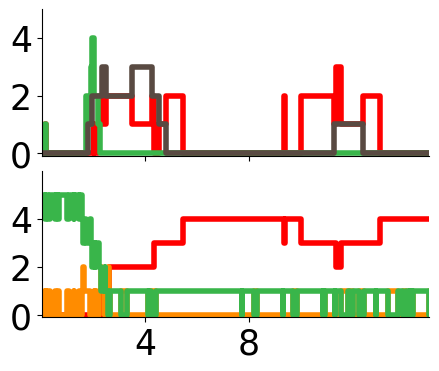

In [2159]:
c_red = (1,0,0)
c_green = np.array([57,181,74])/255
c_brown = np.array([89, 74, 66])/255


fig, ax = plt.subplots(nrows=2, figsize=(5,4), sharex=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax[0].plot(t_rec[:,0], counts[:,0,0], drawstyle='steps-post', linewidth=lw, color=c_red)
ax[0].plot(t_rec[:,0], counts[:,0,1], drawstyle='steps-post', linewidth=lw, color=c_green)
ax[0].plot(t_rec[:,0], counts[:,0,5], drawstyle='steps-post', linewidth=lw, color=c_brown)

ax[0].spines[['right', 'top']].set_visible(False)


ax[1].plot(t_rec[:,0], counts[:,0,2], drawstyle='steps-post', linewidth=lw, color=c_red)
ax[1].plot(t_rec[:,0], counts[:,0,3], drawstyle='steps-post', linewidth=lw, color='darkorange')
ax[1].plot(t_rec[:,0], counts[:,0,4], drawstyle='steps-post', linewidth=lw, color=c_green)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)


ax[0].xaxis.set_ticks([4, 8])
ax[0].yaxis.set_ticks([0,2, 4])
ax[1].yaxis.set_ticks([0,2, 4])
ax[0].set_ylim(-0.1, 5); ax[1].set_ylim(-0.1, 5)

plt.ylim(-0.1, 6)
plt.xlim(0, 15)
plt.subplots_adjust(hspace=0.1)

save_file('gillespie_full_example')
plt.show()

## c. Fluctuations in switch count, the number of marked molecules, and the number of dimers

Using same simulations as in (b), plot fluctuations in the number of switches (i.e., the number of molecules, not counting the reservoir species), the number of marked molecules, and the number of dimers. While the number of marked molecules fluctuates in the models we have considered before now, fluctuations in the number of switches and dimers is a new feature of the 'realistic' model.

In [ ]:
# Quantities of interest
total_num = counts[:,:,0] + counts[:,:,1] + 2*( counts[:,:,2] + counts[:,:,3] + counts[:,:,4] )
num_marked = counts[:,:,1] + 2*( counts[:,:,3] + counts[:,:,4] )
num_dimers = 2*( counts[:,:,2] + counts[:,:,3] + counts[:,:,4] )

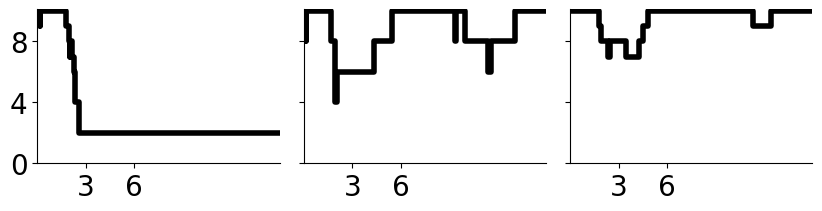

In [2069]:
fig, ax = plt.subplots(ncols=3, figsize=(10,2), sharey=True)

num_samples = 1
for i in range(num_samples):
    ax[0].plot(t_rec[:,i], num_marked[:,i], drawstyle='steps-post', linewidth=lw, color='black')
    ax[1].plot(t_rec[:,i], num_dimers[:,i], drawstyle='steps-post', linewidth=lw, color='black')
    ax[2].plot(t_rec[:,i], total_num[:,i], drawstyle='steps-post', linewidth=lw, color='black')

# labeling loop
for i in range(0, 3):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlim(-0., 15)
    ax[i].set_ylim(0, 10.1)

    ax[i].tick_params(axis='both', which='major', labelsize=20)

    ax[i].xaxis.set_ticks([3, 6])
    ax[i].yaxis.set_ticks([0, 4, 8])

plt.subplots_adjust(wspace=0.1)
save_file('gillespie_full_example_dimers_etc')
plt.show()

## d. Realistic model reduces to Crick switch

The realistic model (black dashed lines) reduces to the Crick switch in the limit that 
- the binding rate $b_f$ is much higher than the unbinding rate $b_r$, and both are small;
- and the monomer gain rate $\alpha$ is much higher than the monomer loss rate $\beta$, and both are small.

In [2165]:
t_min, t_max, num_t = 0, 25, 200
t = np.linspace(t_min, t_max, num_t)

eps, gamma, k = 0.01, 1, 10; params = {'eps':eps, 'gamma':gamma, 'k':k}
_, p_t = get_probs_crick(t, params)
p_minus, p_mid, p_plus = p_t.T      # Crick probs, for comparison

In [2181]:
N = 2

bf_, br_ = 10, 1
alpha_, beta_ = 8, 2

b_scale = 1e-4
N_scale = 1e-4

bf = bf_*b_scale
br = br_*b_scale

alpha = alpha_*N_scale
beta = beta_*N_scale

params = {'eps':eps, 'gamma':gamma, 'k':k, 'alpha':alpha, 'beta':beta, 'bf':bf, 'br':br, 'N':N//2}
params_init = params.copy(); params_init['k'] = 1000


# Get reactions and states
rxns = get_rxn_list_crick_full(params)
rxns_init = get_rxn_list_crick_full(params_init)

constraint = lambda state: ( state[0] + state[1] + 2*(state[2] + state[3] + state[4]) + state[5] == N)
states = enumerate_states_box([(0, N),(0, N),(0, N//2),(0, N//2),(0, N//2),(0, N)], constraint) 

# Build sparse generator matrices
Q, index = build_generator_fsp(states, rxns, add_sink = False)
Q_init, _ = build_generator_fsp(states, rxns_init, add_sink = False)

# Solve models
p0 = np.zeros(len(states))
p0[index.get( (0, 0, 0, 0, N//2, 0) )] = 1

p0_proper = solve_cme_fsp(Q_init, p0, t_init, t_max, 2)[-1,:]
p_t_complex = solve_cme_fsp(Q, p0_proper, t_init, t_max, num_t)

In [2183]:
# Consider combination of realistic model variables that maps to Crick switch states
p_dimer, xvals, _ = joint_marginal_over_vars(p_t_complex, states, keep_vars=[2,3,4])
p_dimer = p_dimer.reshape(num_t, -1)

p_minus_ = p_dimer[:,4]
p_med_ = p_dimer[:,2]
p_plus_ = p_dimer[:,1]

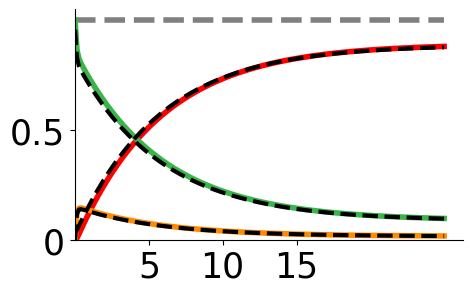

In [2187]:
fig, ax = plt.subplots(figsize=(5,3))


plt.plot(t, np.ones_like(t), color='gray', linestyle='--', linewidth=lw)

plt.plot(t, p_minus, linewidth=lw, color=c_red)
plt.plot(t, p_mid, linewidth=lw, color='darkorange')
plt.plot(t, p_plus, linewidth=lw, color=c_green)

plt.plot(t, p_t_complex[:,3], linestyle='--', zorder=3, color='black', linewidth=lw-1)
plt.plot(t, p_t_complex[:,2], linestyle='--', zorder=3, color='black', linewidth=lw-1)
plt.plot(t, p_t_complex[:,1], linestyle='--', zorder=3, color='black', linewidth=lw-1)

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0,None); plt.ylim(0, 1.05)
plt.xticks([5, 10, 15],fontsize=25)
plt.yticks([0,0.5], ['0','0.5'], fontsize=25)

save_file('reduce_limit_crick')
plt.show()

## e. Mutual information vs time for the realistic model

### Mutual information vs time for the realistic model, different values of binding time scale

Mutual information vs time for the realistic model, different values of the binding time scale. Concretely, we consider binding and unbinding rates $b_f = B \tilde{b}_f$ and $b_r = B \tilde{b}_r$. We fix $\tilde{b}_f$ and $\tilde{b}_r$, and consider different values of $B$ ($B = 0.01, 0.1, 1$). These curves are compared to the MI curve of the corresponding $N$ Crick switch model (black), to which this model reduces in the $B \to 0$ limit.

In [2194]:
def get_crick_binding_solution(t, params, params_init, N):
    t_init, t_final, num_t = t[0], t[-1], len(t)
    
    rxns = get_rxn_list_crick_binding(params)
    rxns_init = get_rxn_list_crick_binding(params_init)

    constraint = lambda state: ( state[0] + state[1] + 2*(state[2] + state[3] + state[4]) == N)
    states = enumerate_states_box([(0, N),(0, N),(0, N//2),(0, N//2),(0, N//2)], constraint) 

    print('num states: ',len(states))

    Q, index = build_generator_fsp(states, rxns, add_sink = False)
    Q_init, _ = build_generator_fsp(states, rxns_init, add_sink = False)

    p0 = np.zeros(len(states))
    p0[index.get( (0, 0, 0, 0, N//2) )] = 1

    p0_proper = solve_cme_fsp(Q_init, p0, t_init, t_final, 2)[-1,:]
    p_t = solve_cme_fsp(Q, p0_proper, t_init, t_final, num_t)

    MI = get_MI(p_t[-1], p_t)    
    return p0_proper, p_t, MI

def get_MI_crick(t, eps, gamma, k, N):
    params = {'eps':eps, 'gamma':gamma, 'k':k, 'N':N//2}
    p_z_given_0, p_z_given_1 = get_probs_ncrick(t, params)
    MI = get_MI(p_z_given_0, p_z_given_1)
    return MI

In [2196]:
t_init, t_final = 1e-5, 40; num_t = 200
t = np.linspace(t_init, t_final, num_t)

eps = 0.01
gamma = 1
k = 10

N = 10

In [2198]:
bf_ = 10
br_ = 1

b_scale = .01    
bf = bf_*b_scale
br = br_*b_scale

params_b_low = {'eps':eps, 'gamma':gamma, 'k':k, 'bf':bf, 'br':br, 'N':N//2}
params_b_low_init = params_b_low.copy(); params_b_low_init['k'] = 1000

p0_proper_b_low, p_b_low, MI_b_low = get_crick_binding_solution(t, params_b_low, params_b_low_init, N)
# ----------

b_scale = .1    
bf = bf_*b_scale
br = br_*b_scale

params_b_med = {'eps':eps, 'gamma':gamma, 'k':k, 'bf':bf, 'br':br, 'N':N//2}
params_b_med_init = params_b_med.copy(); params_b_med_init['k'] = 1000

p0_proper_b_med, p_b_med, MI_b_med = get_crick_binding_solution(t, params_b_med, params_b_med_init, N)

# ------------

b_scale = 1.    
bf = bf_*b_scale
br = br_*b_scale

params_b_hi = {'eps':eps, 'gamma':gamma, 'k':k, 'bf':bf, 'br':br, 'N':N//2}
params_b_hi_init = params_b_hi.copy(); params_b_hi_init['k'] = 1000

p0_proper_b_hi, p_b_hi, MI_b_hi = get_crick_binding_solution(t, params_b_hi, params_b_hi_init, N)

num states:  196
num states:  196
num states:  196


In [2200]:
MI_crick = get_MI_crick(t, eps, gamma, k, N)

t_life_crick = t[np.argwhere(MI_crick <= 0.5*MI_crick[0])[0]]
t_life_b_low = t[np.argwhere(MI_b_low <= 0.5*MI_b_low[0])[0]]
t_life_b_med = t[np.argwhere(MI_b_med <= 0.5*MI_b_med[0])[0]]
t_life_b_hi = t[np.argwhere(MI_b_hi <= 0.5*MI_b_hi[0])[0]]

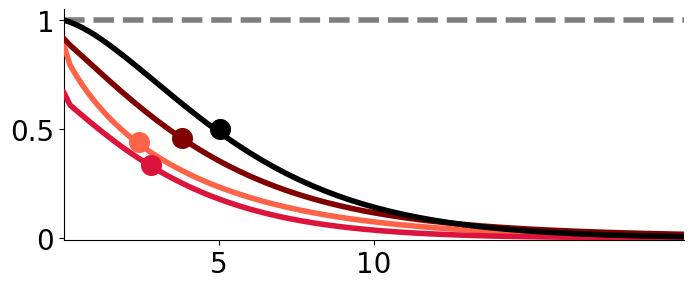

In [2204]:
fig, ax = plt.subplots(figsize=(8,3))


plt.plot(t, MI_b_hi, color=c_b_hi, linewidth=lw, zorder=3)
plt.scatter(t_life_b_hi, 0.5*MI_b_hi[0], color=c_b_hi, s=200, zorder=3)

plt.plot(t, MI_b_med, color=c_b_med, linewidth=lw, zorder=3)
plt.scatter(t_life_b_med, 0.5*MI_b_med[0], color=c_b_med, s=200, zorder=3)

plt.plot(t, MI_b_low, color=c_b_low, linewidth=lw, zorder=3)
plt.scatter(t_life_b_low, 0.5*MI_b_low[0], color=c_b_low, s=200, zorder=3)

plt.plot(t, MI_crick, color='black', linewidth=lw, zorder=3)
plt.scatter(t_life_crick, 0.5*MI_crick[0], color='black', s=200, zorder=3)


plt.plot(t, np.ones_like(t), linestyle='--', color='black', linewidth=4, alpha=0.5) 


ax.spines[['right', 'top']].set_visible(False)
plt.xticks([ 5, 10],fontsize=20)
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=20)
plt.xlim(0., 20); plt.ylim(-0.01, None)
save_file('MI_crick_binding')
plt.show()

### Mutual information vs time for the realistic model, different values of monomer loss time scale

Mutual information vs time for the realistic model, different values of the monomer loss time scale. Concretely, we consider monomer gain and loss rates $\alpha = M \tilde{\alpha}$ and $\beta = M \tilde{\beta}$. We fix $\tilde{\alpha}$ and $\tilde{\beta}$, and consider different values of $M$ ($M = 0.1, 0.5, 1$). These curves are compared to the MI curve of the corresponding $N$ Crick switch model (black), to which this model reduces in the $M \to 0$ limit.

In [2208]:
def get_crick_full_solution(t, params, params_init, N):
    t_init, t_final, num_t = t[0], t[-1], len(t)
    
    rxns = get_rxn_list_crick_full(params)
    rxns_init = get_rxn_list_crick_full(params_init)

    constraint = lambda state: ( state[0] + state[1] + 2*(state[2] + state[3] + state[4]) + state[5] == N)
    states = enumerate_states_box([(0, N),(0, N),(0, N//2),(0, N//2),(0, N//2),(0, N)], constraint) 

    print('num states: ',len(states))

    Q, index = build_generator_fsp(states, rxns, add_sink = False)
    Q_init, _ = build_generator_fsp(states, rxns_init, add_sink = False)

    p0 = np.zeros(len(states))
    p0[index.get( (0, 0, 0, 0, N//2, 0) )] = 1

    p0_proper = solve_cme_fsp(Q_init, p0, t_init, t_final, 2)[-1,:]
    p_t = solve_cme_fsp(Q, p0_proper, t_init, t_final, num_t)

    MI = get_MI(p_t[-1], p_t)    
    return p0_proper, p_t, MI

In [2210]:
t_init, t_final = 1e-5, 40; num_t = 200
t = np.linspace(t_init, t_final, num_t)

eps = 0.01
gamma = 1
k = 10

b_scale = 0.5
bf = 10*b_scale
br = 1*b_scale

N = 10

In [2212]:
alpha_ = 8
beta_ = 2

N_scale = .1    
alpha = alpha_*N_scale
beta = beta_*N_scale

params_f_low = {'eps':eps, 'gamma':gamma, 'k':k, 'alpha':alpha, 'beta':beta, 'bf':bf, 'br':br, 'N':N//2}
params_f_low_init = params_f_low.copy(); params_f_low_init['k'] = 1000

p0_proper_f_low, p_f_low, MI_f_low = get_crick_full_solution(t, params_f_low, params_f_low_init, N)
# ----------

N_scale = .5
alpha = alpha_*N_scale
beta = beta_*N_scale

params_f_med = {'eps':eps, 'gamma':gamma, 'k':k, 'alpha':alpha, 'beta':beta, 'bf':bf, 'br':br, 'N':N//2}
params_f_med_init = params_f_med.copy(); params_f_med_init['k'] = 1000

p0_proper_f_med, p_f_med, MI_f_med = get_crick_full_solution(t, params_f_med, params_f_med_init, N)

# ------------

N_scale = 1.
alpha = alpha_*N_scale
beta = beta_*N_scale

params_f_hi = {'eps':eps, 'gamma':gamma, 'k':k, 'alpha':alpha, 'beta':beta, 'bf':bf, 'br':br, 'N':N//2}
params_f_hi_init = params_f_hi.copy(); params_f_hi_init['k'] = 1000

p0_proper_f_hi, p_f_hi, MI_f_hi = get_crick_full_solution(t, params_f_hi, params_f_hi_init, N)

num states:  630
num states:  630
num states:  630


In [2214]:
MI_crick = get_MI_crick(t, eps, gamma, k, N)

t_life_crick = t[np.argwhere(MI_crick <= 0.5*MI_crick[0])[0]]
t_life_f_low = t[np.argwhere(MI_f_low <= 0.5*MI_f_low[0])[0]]
t_life_f_med = t[np.argwhere(MI_f_med <= 0.5*MI_f_med[0])[0]]
t_life_f_hi = t[np.argwhere(MI_f_hi <= 0.5*MI_f_hi[0])[0]]

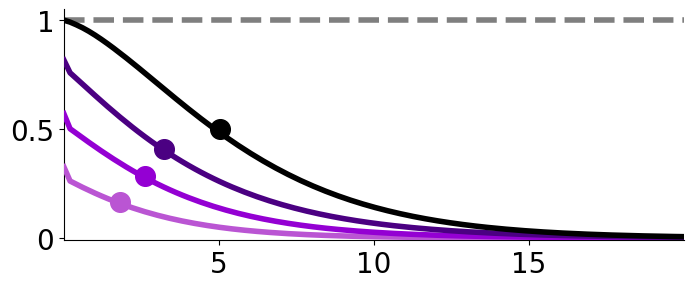

In [2216]:
fig, ax = plt.subplots(figsize=(8,3))


plt.plot(t, MI_f_hi, color=c_N_hi, linewidth=lw, zorder=3)
plt.scatter(t_life_f_hi, 0.5*MI_f_hi[0], color=c_N_hi, s=200, zorder=3)

plt.plot(t, MI_f_med, color=c_N_med, linewidth=lw, zorder=3)
plt.scatter(t_life_f_med, 0.5*MI_f_med[0], color=c_N_med, s=200, zorder=3)

plt.plot(t, MI_f_low, color=c_N_low, linewidth=lw, zorder=3)
plt.scatter(t_life_f_low, 0.5*MI_f_low[0], color=c_N_low, s=200, zorder=3)

plt.plot(t, MI_crick, color='black', linewidth=lw, zorder=3)
plt.scatter(t_life_crick, 0.5*MI_crick[0], color='black', s=200, zorder=3)


plt.plot(t, np.ones_like(t), linestyle='--', color='black', linewidth=4, alpha=0.5) 


ax.spines[['right', 'top']].set_visible(False)
plt.xticks([ 5, 10, 15],fontsize=20)
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=20)
plt.xlim(0., 20); plt.ylim(-0.01, None)

save_file('MI_crick_variance_fixed')
plt.show()

## f. Lifetime, capacity, and performance as functions of binding and monomer loss time scales

Lifetime, capacity, and performance as functions of binding (i.e., $B$) and monomer loss (i.e., $M$) time scales. Values are normalized relative to the values of the corresponding pure Crick switch (which has no binding dynamics or number fluctuations), so closer to $1$ is better. 

In [1133]:
# get MI curve of realistic model
def get_crick_full_MI(b_scale, N_scale, k, t):
    t_init, t_final, num_t = t[0], t[-1], len(t)

    # hyperparameters
    eps = 0.01
    gamma = 1
    N = 10
    
    bf_, br_ = 10, 1
    alpha_, beta_ = 8, 2

    
    bf = bf_*b_scale
    br = br_*b_scale
   
    alpha = alpha_*N_scale
    beta = beta_*N_scale
    
    params = {'eps':eps, 'gamma':gamma, 'k':k, 'alpha':alpha, 'beta':beta, 'bf':bf, 'br':br, 'N':N//2}
    params_init = params.copy(); params_init['k'] = 1000

    
    rxns = get_rxn_list_crick_full(params)
    rxns_init = get_rxn_list_crick_full(params_init)

    constraint = lambda state: ( state[0] + state[1] + 2*(state[2] + state[3] + state[4]) + state[5] == N)
    states = enumerate_states_box([(0, N),(0, N),(0, N//2),(0, N//2),(0, N//2),(0, N)], constraint) 


    Q, index = build_generator_fsp(states, rxns, add_sink = False)
    Q_init, _ = build_generator_fsp(states, rxns_init, add_sink = False)

    p0 = np.zeros(len(states))
    p0[index.get( (0, 0, 0, 0, N//2, 0) )] = 1

    p0_proper = solve_cme_fsp(Q_init, p0, t_init, t_final, 2)[-1,:]
    p_t = solve_cme_fsp(Q, p0_proper, t_init, t_final, num_t)

    MI = get_MI(p_t[-1], p_t)
    return MI


# given MI curve, extract summary stats of interest (lifetime, capacity, performance)
def get_statistics(t, MI, tau = 100):
    t_life = t[np.argwhere(MI <= 0.5*MI[0])[0][0]]
    C = MI[0]
    J = np.trapz(MI*np.exp(-t/tau), x=t  )/tau
    return t_life, C, J

In [1361]:
t_init, t_final = 1e-5, 40; num_t = 200
t = np.linspace(t_init, t_final, num_t)


b_scale_list = np.logspace(-3, 0, 10)
N_scale_list = np.logspace(-3, 0, 10)

num_b = len(b_scale_list)
num_N = len(N_scale_list)

# need to run for different values of k: k = 0, 1, 10, 100
k = 100; k_label = str(k)
eps = 0.01; gamma = 1; N = 10; MI_base = get_MI_crick(t, eps, gamma, k, N)

MI_k = np.zeros((num_b, num_N, num_t))
for i in range(num_b):
    for j in range(num_N):
        print('b_scale: ', b_scale_list[i], 'N_scale: ', N_scale_list[j])
        MI_k[i,j,:] = get_crick_full_MI(b_scale_list[i], N_scale_list[j], k, t)

b_scale:  0.001 N_scale:  0.001
b_scale:  0.001 N_scale:  0.0021544346900318843
b_scale:  0.001 N_scale:  0.004641588833612777
b_scale:  0.001 N_scale:  0.01
b_scale:  0.001 N_scale:  0.021544346900318832
b_scale:  0.001 N_scale:  0.046415888336127774
b_scale:  0.001 N_scale:  0.1
b_scale:  0.001 N_scale:  0.21544346900318823
b_scale:  0.001 N_scale:  0.46415888336127775
b_scale:  0.001 N_scale:  1.0
b_scale:  0.0021544346900318843 N_scale:  0.001
b_scale:  0.0021544346900318843 N_scale:  0.0021544346900318843
b_scale:  0.0021544346900318843 N_scale:  0.004641588833612777
b_scale:  0.0021544346900318843 N_scale:  0.01
b_scale:  0.0021544346900318843 N_scale:  0.021544346900318832
b_scale:  0.0021544346900318843 N_scale:  0.046415888336127774
b_scale:  0.0021544346900318843 N_scale:  0.1
b_scale:  0.0021544346900318843 N_scale:  0.21544346900318823
b_scale:  0.0021544346900318843 N_scale:  0.46415888336127775
b_scale:  0.0021544346900318843 N_scale:  1.0
b_scale:  0.004641588833612777 N

In [1363]:
with open('results/data/full_MIgrid_'+k_label+'.pickle', 'wb') as f:
            pickle.dump(MI_k, f)

In [2226]:
b_scale_list = np.logspace(-3, 0, 10)
N_scale_list = np.logspace(-3, 0, 10)

num_b = len(b_scale_list)
num_N = len(N_scale_list)

k_label_list = ['0', '1', '10', '100']

MI_list = []; MI_base_list = []
t_life_list = []; C_list = []; J_list = []


for k_label in k_label_list:
    k = float(k_label)

    t_init, t_final = 1e-5, 40; num_t = 200
    t = np.linspace(t_init, t_final, num_t)

    eps = 0.01; gamma = 1; N = 10; 
    MI_base_ = get_MI_crick(t, eps, gamma, k, N); MI_base_list.append( MI_base_ )
    
    with open('results/data/full_MIgrid_'+k_label+'.pickle', 'rb') as f:
                MI_ = pickle.load(f); MI_list.append(MI_)

    t_life_k = np.zeros((num_b, num_N)) 
    C_k = np.zeros((num_b, num_N)) 
    J_k = np.zeros((num_b, num_N)) 

    for i in range(num_b):
        for j in range(num_N):
            t_life_k[i,j], C_k[i,j], J_k[i,j] = get_statistics(t, MI_[i,j], tau=100)
    
    t_life_base, C_base, J_base = get_statistics(t, MI_base_, tau=100)

    t_life_list.append(t_life_k/t_life_base)
    C_list.append(C_k/C_base)
    J_list.append(J_k/J_base)

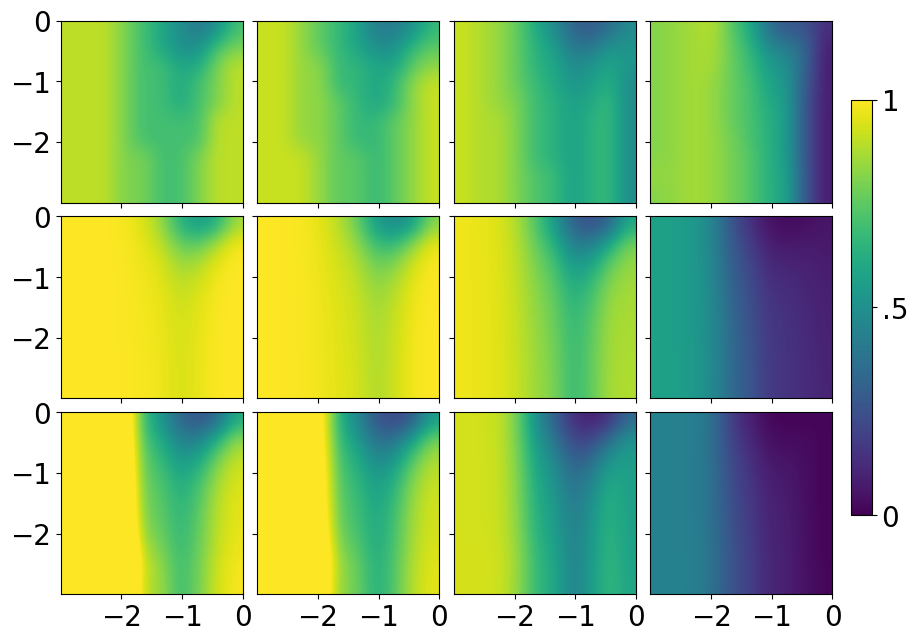

In [2228]:
ticksize = 20

fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(12, 9))

for i in range(0, len(k_label_list)):
    ax[0,i].imshow( t_life_list[i].T, origin='lower', interpolation='bicubic', extent=[-3, 0, -3, 0], vmin=0, vmax=1)
    ax[1,i].imshow( C_list[i].T, origin='lower', interpolation='bicubic', extent=[-3, 0, -3, 0], vmin=0, vmax=1)
    im = ax[2,i].imshow( J_list[i].T, origin='lower', interpolation='bicubic', extent=[-3, 0, -3, 0], vmin=0, vmax=1)


for i in range(0, 3):
    for j in range(0, 4):
        ax[i,j].tick_params(axis='both', which='major', labelsize=ticksize)

        ax[i,j].xaxis.set_ticks([-2, -1, 0])
        ax[i,j].yaxis.set_ticks([-2, -1, 0])


plt.subplots_adjust(wspace=0.08, hspace=-0.35)
cb = fig.colorbar(im, ax=ax.ravel().tolist(), location='right', ticks=[0, 0.5, 1], shrink=0.6, pad=0.02)
cb.ax.tick_params(labelsize=ticksize)
cb.ax.set_yticklabels(['0','.5','1'])


save_file('crick_full_bn_big')
plt.show()

## g., h., i. Lifetime, capacity, and performance vs catalysis rate $k$ for the realistic model

Lifetime, capacity, and performance vs the catalysis rate $k$, for different values of $B$ ($B = 0.01, 0.1, 1$). $M$ is fixed at $0.1$ since model behavior is less sensitive to it.

In [1696]:
t_init, t_final = 1e-5, 40; num_t = 500
t = np.linspace(t_init, t_final, num_t)


b_scale_list = [0.01, 0.1, 1]
N_scale = 0.1
k_list = np.linspace(0, 100, 40)

num_b = len(b_scale_list)
num_k = len(k_list)


MI_k2 = np.zeros((num_b, num_k, num_t))
for i in range(num_b):
    for j in range(num_k):
        print('b_scale: ', b_scale_list[i], 'k: ', k_list[j])
        MI_k2[i,j,:] = get_crick_full_MI(b_scale_list[i], N_scale, k_list[j], t)

b_scale:  0.01 k:  0.0
b_scale:  0.01 k:  2.5641025641025643
b_scale:  0.01 k:  5.128205128205129
b_scale:  0.01 k:  7.692307692307693
b_scale:  0.01 k:  10.256410256410257
b_scale:  0.01 k:  12.820512820512821
b_scale:  0.01 k:  15.384615384615387
b_scale:  0.01 k:  17.94871794871795
b_scale:  0.01 k:  20.512820512820515
b_scale:  0.01 k:  23.07692307692308
b_scale:  0.01 k:  25.641025641025642
b_scale:  0.01 k:  28.205128205128208
b_scale:  0.01 k:  30.769230769230774
b_scale:  0.01 k:  33.333333333333336
b_scale:  0.01 k:  35.8974358974359
b_scale:  0.01 k:  38.46153846153847
b_scale:  0.01 k:  41.02564102564103
b_scale:  0.01 k:  43.58974358974359
b_scale:  0.01 k:  46.15384615384616
b_scale:  0.01 k:  48.71794871794872
b_scale:  0.01 k:  51.282051282051285
b_scale:  0.01 k:  53.846153846153854
b_scale:  0.01 k:  56.410256410256416
b_scale:  0.01 k:  58.97435897435898
b_scale:  0.01 k:  61.53846153846155
b_scale:  0.01 k:  64.1025641025641
b_scale:  0.01 k:  66.66666666666667
b_sca

In [1698]:
with open('results/data/full_MIgrid_p2.pickle', 'wb') as f:
            pickle.dump(MI_k2, f)

In [ ]:
# OPTIONAL: load results
# with open('results/data/full_MIgrid_p2.pickle', 'rb') as f:
#             pickle.load(MI_k2, f)

In [2117]:
t_init, t_final = 1e-5, 40; num_t = 500
t = np.linspace(t_init, t_final, num_t)


b_scale_list = [0.01, 0.1, 1]
N_scale = 0.1
k_list = np.linspace(0, 100, 40)

num_b = len(b_scale_list)
num_k = len(k_list)

In [2119]:
t_life_k = np.zeros((num_b, num_k)) 
C_k = np.zeros((num_b, num_k)) 
J_k = np.zeros((num_b, num_k)) 

for i in range(num_b):
    for j in range(num_k):
        t_life_k[i,j], C_k[i,j], J_k[i,j] = get_statistics(t, MI_k2[i,j], tau=100)

In [ ]:
from scipy.signal import savgol_filter

window = 5

# do filtering to remove discreteness issue
t_life_filter_0 = savgol_filter(t_life_k[0,:], window, 2)
t_life_filter_1 = savgol_filter(t_life_k[1,:], window, 2)
t_life_filter_2 = savgol_filter(t_life_k[2,:], window, 2)   

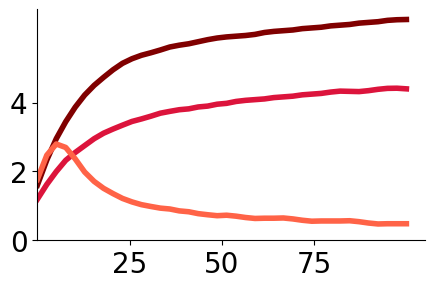

In [2127]:
colors = [c_b_low, c_b_med, c_b_hi]


fig, ax = plt.subplots(figsize=(5,3))

plt.plot(k_list, t_life_filter_0, linewidth=lw, color=colors[0])
plt.plot(k_list, t_life_filter_1, linewidth=lw, color=colors[1])
plt.plot(k_list, t_life_filter_2, linewidth=lw, color=colors[2])

plt.xticks([25, 50, 75],fontsize=20); 
plt.yticks([0, 2, 4], fontsize=20);   
ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0, None); plt.ylim(0, None)

save_file('lifetime_crick_full_vs_k')
plt.show()

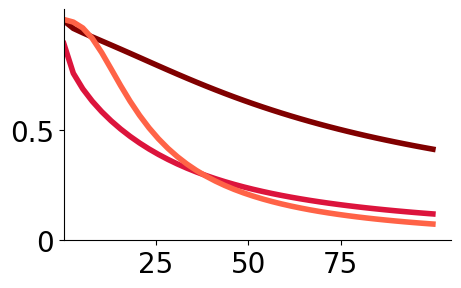

In [2129]:
fig, ax = plt.subplots(figsize=(5,3))

for i in range(num_b):
    plt.plot(k_list, C_k[i,:], linewidth=lw, color=colors[i])

plt.xticks([25, 50, 75],fontsize=20); 
plt.yticks([0, 0.5], ['0', '0.5'], fontsize=20);  
ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0, None); plt.ylim(0, None)

save_file('capacity_crick_full_vs_k')
plt.show()

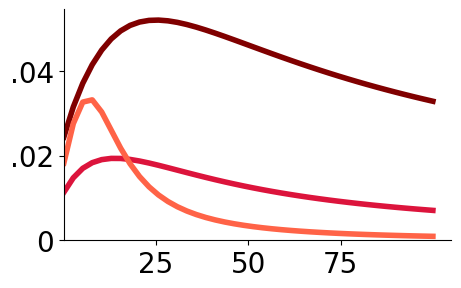

In [2125]:
fig, ax = plt.subplots(figsize=(5,3))

for i in range(num_b):
    plt.plot(k_list, J_k[i,:], linewidth=lw, color=colors[i])

plt.xticks([25, 50, 75],fontsize=20); 
plt.yticks([0, 0.02, 0.04], ['0', '.02', '.04'],fontsize=20);  
ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0, None); plt.ylim(0, None)

save_file('performance_crick_full_vs_k')
plt.show()